# Chapter 6. 게이트가 추가된 RNN

최근 RNN 대신 LSTM, GRU 계층이 주로 쓰인다.
기본적인 RNN이라고 부른다.

* LSTM, GRU
    * 게이트(gate)라는 구조가 더해진다.
    * 시계열 데이터의 장기 의존 관계 학습이 가능하다.
    * 게이트가 추가된 RNN

## RNN의 문제점
* RNN : 시계열 데이터 장기 의존 관계 학습이 어렵다.
    * BPTT에서 기울기 소실 혹은 기울기 폭발이 발생하기 때문
    * RNN 계층이 장기 기억을 제대로 처리 못하는 이유?
    

### RNN 복습
![img](./images/fig_6-1.png)
* 은닉 상태($h_t$) : 과거 정보 저장
* 이전 시각의 은닉 상태를 이용한다. 과거 정보 계승 가능.

![img](./images/fig_6-2.png)

### 기울기 소실 또는 기울기 폭발의 원인
* RNN 계층의 시간 방향 기울기 전파
![img](./images/fig_6-5.png)

* 역전파로 전해지는 기울기 : tanh, +, MatMul 연산을 통과
* + 역전파 : 기울기 변화가 없음
* tanh 역전파 : 값이 1.0 이하이고, x가 0에서 멀어질수록 작아진다.
![img](./images/fig_6-6.png)

* RNN : tanh 함수보다 ReLU 활성화 함수를 사용하면 기울기 소실을 줄일 수 있다.
* MatMul 역전파 : tanh 노드를 무시하면, 기울기가 오직 MatMul 연산으로 변화
![img](./images/fig_6-7.png)

    * 행렬 곱셈에서는 매번 똑같은 가중치 $W_h$가 사용된다.

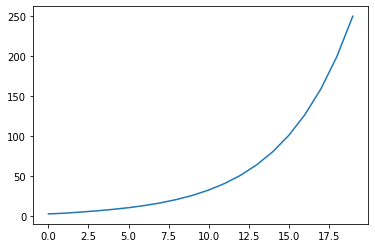

In [15]:
# MatMul 역전파 시 기울기 변화
import numpy as np
import matplotlib.pyplot as plt

N = 2 # 미니배치 크기
H = 3
T = 20

dh = np.ones((N, H))
np.random.seed(3) # 재현 가능하도록 난수의 시드 고정
Wh = np.random.randn(H, H)

norm_list = []
for t in range(T):
    dh = np.matmul(dh, Wh.T)
    norm = np.sqrt(np.sum(dh**2)) / N
    norm_list.append(norm)

plt.plot(norm_list)
plt.show()

* 기울기 폭발(exploding gradient) : 기울기 크기는 시간에 비례해 지수적으로 증가
* 오버플로 : NaN 발생 : 학습 제대로 수행 불가

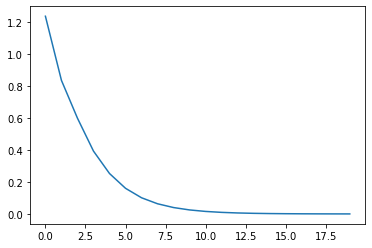

In [14]:
# MatMul 역전파 시 기울기 변화 : 초깃값 변경
import numpy as np
import matplotlib.pyplot as plt

N = 2 # 미니배치 크기
H = 3
T = 20

dh = np.ones((N, H))
np.random.seed(3) # 재현 가능하도록 난수의 시드 고정
Wh = np.random.randn(H, H) * 0.5 # 변경

norm_list = []
for t in range(T):
    dh = np.matmul(dh, Wh.T)
    norm = np.sqrt(np.sum(dh**2)) / N
    norm_list.append(norm)

plt.plot(norm_list)
plt.show()

* 기울기 소실(vanishing gradient) : 초기값을 변경했을 때, 기울기 dh가 시간 크기에 비례해 지수적으로 감소한다.
    
        Wh = np.random.randn(H, H) # 변경 전
        Wh = np.random.randn(H, H) * 0.5 # 변경

* 기울기 소실 : 기울기가 매우 빠르게 작아진다.
    * 가중치 매개변수 더이상 갱신 안된다.
    * 장기 의존 관계 학습 불가능
    * 행렬 Wh를 T번 반복해서 **곱**했기 때문에 발생
    * 행렬이라면 _특잇값_이 척도가 된다. 
    
* 특잇값 : 데이터가 퍼진 정도 나타낸다.
    * 특잇값 중 최댓값이 1보다 큰지 여부 살피기 : 기울기 크기 변화 예측 가능
        * 1보다 크다 : 지수적 증가 가능성이 높다
        * 1보다 작다 : 지수적으로 감소 가능성이 높다
       

### 기울기 폭발 대책

* 기울기 폭발의 대책 : 기울기 클리핑(gradient clipping). 
$$ if \ \lVert\hat{g}\rVert \gt threshold: \\ \hat{g} = {threshold \over ||\hat{g}||} \hat{g}$$


In [16]:
import numpy as np

dW1 = np.random.rand(3, 3) * 10
dW2 = np.random.rand(3, 3) * 10
grads = [dW1, dW2]
max_norm = 5.0

def clip_grads(grads, max_norm):
    total_norm = 0
    for grad in grads:
        total_norm += np.sum(grad ** 2)
    total_norm = np.sqrt(total_norm)
    
    rate = max_norm / (total_norm + 1e-6)
    if rate < 1:
        for grad in grads:
            grad += rate

## 기울기 소실과 LSTM

* 게이트가 추가된 RNN : LSTM, GRU

### LSTM의 인터페이스
![img](./images/fig_6-10.png)

tanh 직사각형 노드 : $\tanh(\mathbf{h_{t-1}W_h + x_tW_x + b})$

![img](./images/fig_6-11.png)

RNN과 다르게 LSTM 계층에는 **c** 경로가 있다.  
c : 기억 셀(memory cell, 셀), LSTM 전용 기억 메커니즘  
* 기억 셀의 특징
    * 데이터를 자기 자신(LSTM 계층 내에서만) 주고 받는다.
    * LSTM 계층 내에서만 완결되고 다른 계층 출력하지 않는다.
    * LSTM 은닉 상태 h : RNN 처럼 다른 계층으로 출력(위쪽)


### LSTM 계층 조립하기
* LSTM 기억 셀 $c_t$ : 시각 t에서 LSTM 기억이 저장
    * 과거부터 시각 t까지 필요한 모든 정보 저장 가정
    * 외부 계층에 다음 시각 LSTM에 은닉 상태 $h_t$ 출력
    * $h_t$ : 기억 셀의 값을 tanh 함수로 변환한 값

![img](./images/fig_6-12.png)

* 갱신된 $c_t$를 사용해 은닉 상태 $h_t$ 계산한다.($h_t = \tanh{(c_t)}$)
    * $c_t$의 각 요소에 tanh 함수를 적용한다.
    
* 게이트 : 물의 흐름을 제어
![img](./images/fig_6-13.png)


* 어느 정도 : 열림 상태(openness)
    * 0.0과 1.0 사이 실수로 나타낸다.
    * 그 값이 다음 흐르는 물의 양을 결정
    * 게이트를 얼마나 열까도 데이터로부터 자동으로 학습한다.
![img](./images/fig_6-14.png)

### output 게이트
* output 게이트(출력 게이트) : 다음 은닉 상태 $h_t$의 출력을 담당하는 게이트
    * $\tanh{c_t}$에 게이트를 적용 : 각 원소에 대해 그것이 다음 시각의 은닉 상태에 얼마나 중요한가를 조정
* output 게이트 열림 상태 : 입력과 이전 상태에서 구한다.
$$\mathbf{o} = \sigma(\mathbf{x_tW_x^{(o)} + h_{t-1}W_h^{(o)} + b^{(o)}})$$

![img](./images/fig_6-15.png)
* 아다마르 곱(Hadamard product) : 원소별 곱
$$\mathbf{h_t = o \odot \tanh(c_t)} $$

### forget 게이트
게이트를 사용해 기억 셀에 _무엇을 잊을까_를 명확히 지시한다.
* forget 게이트(망각 게이트) : $c_{t-1}$의 기억 중 불필요한 기억을 지우는 게이트

![img](./images/fig_6-16.png)

$$\mathbf{f} = \sigma(\mathbf{x_tW_x^{(f)} + h_{t-1}W_h^{(f)} + b^{(f)}})$$

$$\mathbf{c_t = f \odot c_{t-1}}$$
* 망각 게이트 출력값 f와 이전 기억 셀인 $c_{t-1}$의 원소별 곱으로 구할 수 있다.

### 새로운 기억 셀
* 기억 셀에서 잊어야 할 기억이 삭제 된다. 이 때, 새로 기억해야 할 정보를 기억 셀에 추가한다.
* tanh 노드 추가
![img](./images/fig_6-17.png)

* tanh 노드 결과가 이전 시각의 기억 셀에 더해진다.(새로운 정보가 기억 셀에 추가된 것이다.)
    * tanh 노드는 게이트가 아니고, 새 정보를 기억 셀에 추가한다.
    * 활성화 함수를 시그모이드가 아니라 tanh 함수가 사용된다.
    $$\mathbf{g} = \tanh(\mathbf{x_tW_x^{(g)} + h_{t-1}W_h^{(g)} + b^{(g)}})$$

* g가 이전 시각의 기억 셀 $c_{t-1}$에 더해져서 새로운 기억이 생긴다.


### input 게이트
g에 input 게이트(입력 게이트)를 추가하면 계산 그래프는 다음과 같다.
![img](./images/fig_6-18.png)

$$\mathbf{i} = \sigma(\mathbf{x_tW_x^{(i)} + h_{t-1}W_h^{(i)} + b^{(i)}})$$

이후에 i와 g의 원소별 곱 결과를 기억 셀에 추가한다.  
LSTM에는 변종이 몇 가지 있다. 게이트 연결 방법이 약간 다른 계층도 볼 수 있다.


### LSTM의 기울기 흐름
* 기울기 소실 제거 원리 : 기억 셀 c의 역전파에 주목
![img](./images/fig_6-19.png)

* 기억 셀에서 역전파의 흐름을 그린다.  
* 기억 셀의 역전파에는 +와 x 노드만을 지나게 된다.  
* '+' 노드는 기울기를 그대로 흐르므로, 기울기 변화(감소) 발생하지 않는다.  
* 'x' 노드 : 원소별 곱(아마다르 곱) 계산한다. 행렬 곱이 아니다.
    * 매번 새로운 게이트 값을 이용해 원소별 곱을 계산한다.
    * 매번 새로운 게이트 값을 이용하므로 곱셈의 효과가 누적되지 않는다.
    * 기울기 소실이 일어나기 어렵다.
    * forget 게이트가 제어
        * 잊어야 한다고 판단한 기억 셀의 기울기가 작아진다.
        * 잊어서는 안된다 판단 원소 : 기울기가 약화되지 않은 채로 과거 방향 흐름
            * 기울기가 소실 없이 전파 기대 가능
* 기억 셀이 장기 의존 관계를 유지(학습)하리라 기대 가능  

* LSTM(Long Short-Term Memory) : 단기 기억을 긴 시간 지속할 수 있음을 의미한다.




## LSTM 구현

In [17]:
#LSTM 클래스 초기화 코드
class LSTM:
    def __init__(self, Wx, Wh, b):
        self.params = [Wx, Wh, b]
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
        self.cache = None

In [18]:
# 순전파 구현
def forward(self, x, h_prev, c_prev):
    Wx, Wh, b = self.params
    N, H = h_prev.shape
    
    A = np.matmul(x, Wx) + np.matmul(h_prev, Wh) + b
    
    # 슬라이스
    f = A[:, :H]
    g = A[:, H:2*H]
    i = A[:, 2*H:3*H]
    o = A[:, 3*H:]
    
    f = sigmoid(f)
    g = np.tanh(g)
    i = sigmoid(i)
    o = sigmoid(o)
    
    c_next = f * c_prev + g * i
    h_next = o * np.tanh(c_next)
    
    self.cache = (x, h_prev, c_prev, i, f, g, o, c_next)
    return h_next, c_next

* 4개 행렬을 한번에 연결할 수 있다.
    
        dA = np.hstack((df, dg, di, do))

### Time LSTM 구현
![img](./images/fig_6-24.png)
![img](./images/fig_6-25.png)

In [20]:
# Time LSTM
class TimeLSTM:
    def __init__(self, Wx, Wh, b, stateful = False):
        self.params = [Wx, Wh, b]
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
        self.layers = None
        self.h, self.c = None, None
        self.dh = None
        self.stateful = stateful
        
    def forward(self, xs):
        Wx, Wh, b = self.params
        N, T, D = xs.shape
        H = Wh.shape[0]
        
        self.layers = []
        hs = np.empty((N, T, H), dtype = 'f')
        
        if not self.stateful or self.h is None:
            self.h = np.zeros((N, H), dtype = 'f')
        if not self.stateful or self.c is None:
            self.c = np.zeros((N, H), dtype = 'f')
            
        for t in range(T):
            layer = LSTM(*self.params)
            self.h, self.c = layer.forward(xs[:, t, :], self.h, self.c)
            hs[:, t, :] = self.h
            
            self.layers.append(layer)
            
        return hs
    
    def backward(self, dhs):
        Wx, Wh, b = self.params
        N, T, H = dhs.shape
        D = Wx.shape[0]
        
        grads = [0, 0, 0]
        for t in reversed(range(T)):
            layer = self.layers[t]
            dx, dh, dc = layer.backward(dhs[:, t, :] + dh, dc)
            dxs[:, t, :] = dx
            for i, grad in enumerate(layer.grads):
                grads[i] += grad
                
        for i, grad in enumerate(grads):
            self.grads[i][...] = grad
            self.dh = dh
            return dxs
        
        def set_state(self, h, c= None):
            self.h, self.c = h, c
            
        def reset_state(self):
            self.h, self.c = None, None

## LSTM을 사용한 언어 모델

In [25]:
import sys
sys.path.append('..')
from common.time_layers import *
from common.base_model import BaseModel


class Rnnlm(BaseModel):
    def __init__(self, vocab_size=10000, wordvec_size=100, hidden_size=100):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn

        # 가중치 초기화
        embed_W = (rn(V, D) / 100).astype('f')
        lstm_Wx = (rn(D, 4 * H) / np.sqrt(D)).astype('f')
        lstm_Wh = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b = np.zeros(4 * H).astype('f')
        affine_W = (rn(H, V) / np.sqrt(H)).astype('f')
        affine_b = np.zeros(V).astype('f')

        # 계층 생성
        self.layers = [
            TimeEmbedding(embed_W),
            TimeLSTM(lstm_Wx, lstm_Wh, lstm_b, stateful=True),
            TimeAffine(affine_W, affine_b)
        ]
        self.loss_layer = TimeSoftmaxWithLoss()
        self.lstm_layer = self.layers[1]

        # 모든 가중치와 기울기를 리스트에 모은다.
        self.params, self.grads = [], []
        for layer in self.layers:
            self.params += layer.params
            self.grads += layer.grads

    def predict(self, xs):
        for layer in self.layers:
            xs = layer.forward(xs)
        return xs

    def forward(self, xs, ts):
        score = self.predict(xs)
        loss = self.loss_layer.forward(score, ts)
        return loss

    def backward(self, dout=1):
        dout = self.loss_layer.backward(dout)
        for layer in reversed(self.layers):
            dout = layer.backward(dout)
        return dout

    def reset_state(self):
        self.lstm_layer.reset_state()
        
    def save_params(self, file_name = 'Rnnlm.pkl'):
        with open(file_name, 'wb') as f:
            pickle.dump(self.params, f)
            
    def load_params(self, file_name='Rnnlm.pkl'):
        with open(file_name, 'rb') as f:
            self.params = pickle.load(f)

| 에폭 1 |  반복 1 / 1327 | 시간 0[s] | 퍼플렉서티 9999.62
| 에폭 1 |  반복 21 / 1327 | 시간 5[s] | 퍼플렉서티 2977.73
| 에폭 1 |  반복 41 / 1327 | 시간 12[s] | 퍼플렉서티 1225.35
| 에폭 1 |  반복 61 / 1327 | 시간 18[s] | 퍼플렉서티 983.73
| 에폭 1 |  반복 81 / 1327 | 시간 26[s] | 퍼플렉서티 773.35
| 에폭 1 |  반복 101 / 1327 | 시간 32[s] | 퍼플렉서티 680.35
| 에폭 1 |  반복 121 / 1327 | 시간 39[s] | 퍼플렉서티 635.75
| 에폭 1 |  반복 141 / 1327 | 시간 45[s] | 퍼플렉서티 589.79
| 에폭 1 |  반복 161 / 1327 | 시간 50[s] | 퍼플렉서티 577.12
| 에폭 1 |  반복 181 / 1327 | 시간 56[s] | 퍼플렉서티 584.00
| 에폭 1 |  반복 201 / 1327 | 시간 61[s] | 퍼플렉서티 497.28
| 에폭 1 |  반복 221 / 1327 | 시간 67[s] | 퍼플렉서티 482.65
| 에폭 1 |  반복 241 / 1327 | 시간 73[s] | 퍼플렉서티 452.93
| 에폭 1 |  반복 261 / 1327 | 시간 79[s] | 퍼플렉서티 459.99
| 에폭 1 |  반복 281 / 1327 | 시간 85[s] | 퍼플렉서티 460.69
| 에폭 1 |  반복 301 / 1327 | 시간 91[s] | 퍼플렉서티 388.41
| 에폭 1 |  반복 321 / 1327 | 시간 97[s] | 퍼플렉서티 346.31
| 에폭 1 |  반복 341 / 1327 | 시간 103[s] | 퍼플렉서티 396.80
| 에폭 1 |  반복 361 / 1327 | 시간 110[s] | 퍼플렉서티 397.60
| 에폭 1 |  반복 381 / 1327 | 시간 115[s] | 퍼플렉서티 335.76
| 

| 에폭 3 |  반복 541 / 1327 | 시간 988[s] | 퍼플렉서티 136.05
| 에폭 3 |  반복 561 / 1327 | 시간 994[s] | 퍼플렉서티 118.63
| 에폭 3 |  반복 581 / 1327 | 시간 999[s] | 퍼플렉서티 105.17
| 에폭 3 |  반복 601 / 1327 | 시간 1004[s] | 퍼플렉서티 146.81
| 에폭 3 |  반복 621 / 1327 | 시간 1009[s] | 퍼플렉서티 144.27
| 에폭 3 |  반복 641 / 1327 | 시간 1014[s] | 퍼플렉서티 129.53
| 에폭 3 |  반복 661 / 1327 | 시간 1019[s] | 퍼플렉서티 119.96
| 에폭 3 |  반복 681 / 1327 | 시간 1025[s] | 퍼플렉서티 99.38
| 에폭 3 |  반복 701 / 1327 | 시간 1030[s] | 퍼플렉서티 119.09
| 에폭 3 |  반복 721 / 1327 | 시간 1035[s] | 퍼플렉서티 127.37
| 에폭 3 |  반복 741 / 1327 | 시간 1040[s] | 퍼플렉서티 108.11
| 에폭 3 |  반복 761 / 1327 | 시간 1046[s] | 퍼플렉서티 102.94
| 에폭 3 |  반복 781 / 1327 | 시간 1051[s] | 퍼플렉서티 103.79
| 에폭 3 |  반복 801 / 1327 | 시간 1056[s] | 퍼플렉서티 115.19
| 에폭 3 |  반복 821 / 1327 | 시간 1062[s] | 퍼플렉서티 116.19
| 에폭 3 |  반복 841 / 1327 | 시간 1067[s] | 퍼플렉서티 115.75
| 에폭 3 |  반복 861 / 1327 | 시간 1072[s] | 퍼플렉서티 122.10
| 에폭 3 |  반복 881 / 1327 | 시간 1077[s] | 퍼플렉서티 106.27
| 에폭 3 |  반복 901 / 1327 | 시간 1083[s] | 퍼플렉서티 132.80
| 에폭 3 |  반복 921

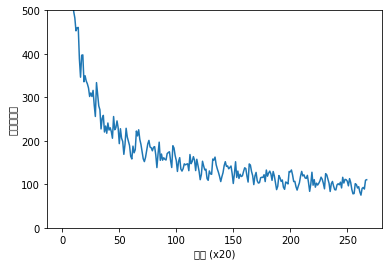

퍼플렉서티 평가 중 ...
234 / 235
테스트 퍼플렉서티:  135.73126387784632


In [29]:
# PTB 데이터셋 학습
import sys
sys.path.append('..')
from common.optimizer import SGD
from common.trainer import RnnlmTrainer
from common.util import eval_perplexity
from dataset import ptb
from rnnlm import Rnnlm
import warnings 
warnings.filterwarnings('ignore')

# 하이퍼파라미터 설정
batch_size = 20
wordvec_size = 100
hidden_size = 100  # RNN의 은닉 상태 벡터의 원소 수
time_size = 35     # RNN을 펼치는 크기
lr = 20.0
max_epoch = 4
max_grad = 0.25

# 학습 데이터 읽기
corpus, word_to_id, id_to_word = ptb.load_data('train')
corpus_test, _, _ = ptb.load_data('test')
vocab_size = len(word_to_id)
xs = corpus[:-1]
ts = corpus[1:]

# 모델 생성
model = Rnnlm(vocab_size, wordvec_size, hidden_size)
optimizer = SGD(lr)
trainer = RnnlmTrainer(model, optimizer)

# 기울기 클리핑을 적용하여 학습
trainer.fit(xs, ts, max_epoch, batch_size, time_size, max_grad,
            eval_interval=20)
trainer.plot(ylim=(0, 500))

# 테스트 데이터로 평가
model.reset_state()
ppl_test = eval_perplexity(model, corpus_test)
print('테스트 퍼플렉서티: ', ppl_test)

# 매개변수 저장
model.save_params()

* fit() 메서드

        # 기울기 구하기
        model.forward(...)
        model.backward(...)
        params, grads = model.params, model.grads
        
        # 기울기 클리핑
        if max_grad is not None:
            clip_grads(grads, max_grads)

        # 매개변수 갱신
        optimizer.update(params, grads)

## RNNLM 추가 개선
### LSTM 계층 다층화
### 드롭아웃에 의한 과적합 억제
* 정규화
* 드롭아웃
* 변형 드롭아웃(Variational Dropout)

### 가중치 공유
### 개선된 RNNLM 구현

In [ ]:
# BetterRnnlm 클래스 구현
!cat better_rnnlm.py

In [ ]:
!cat train_better_rnnlm.py

### 첨단 연구로
![img](./images/fig_6-37.png)

## 정리
* 단순한 RNN 학습에서는 기울기 소실과 기울기 폭발이 문제가 됨
* 기울기 폭발에는 기울기 클리핑, 기울기 소실에는 게이트 추가된 RNN(LSTM, GRU)등이 효과적이다.
* LSTM에는 input 게이트, forget 게이트, output 게이트 등 3개의 게이트가 있다.
* 게이트에는 전용 가중치가 있으며, 시그모이드 함수로 0.0 ~ 1.0 사이의 실수를 출력한다.
* 언어 모델 개선에는 LSTM 계층 다층화, 드롭아웃, 가중치 공유 등의 기법이 효과적이다.
* RNN의 정규화는 중요한 주제이며 드롭아웃 기반의 다양한 기법이 제안되고 있다.